In [9]:
import pandas as pd
import openpyxl
import numpy as np
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import os
import sys

In [10]:
import pmp_functions_v5 as pmp

In [11]:
# --- 1. DEFINE THE MISSING HELPER FUNCTION ---
def process_bloomberg_sheet(df, remove_header_rows=0):
    """
    Standard cleaning for Excel exports.
    1. Removes top N metadata rows.
    2. Finds the header row containing 'Date'.
    3. Resets index.
    """
    df = df.iloc[remove_header_rows:].copy()
    
    # Simple clean: Ensure we don't have empty rows at the top
    df = df.dropna(how='all')
    
    # If the first column isn't "Date", try to find the header
    # (This is a failsafe if headers are on row 3, for example)
    if "Date" not in df.columns:
        # Try to find the row that contains "Date"
        for i in range(min(10, len(df))):
            row_vals = df.iloc[i].astype(str).values
            if "Date" in row_vals:
                df.columns = df.iloc[i]
                df = df.iloc[i+1:]
                break
    
    return df


Loading Eq...
Loading Bd...
Loading Rt...
Loading FX...

--- RUNNING STRATEGY: EQUITY ---
   Assets: 7
   Realized Vol (Unscaled): 11.79%
   Scaling Factor: 0.85x

--- RUNNING STRATEGY: BOND ---
   Assets: 7
   Realized Vol (Unscaled): 5.68%
   Scaling Factor: 1.76x

--- RUNNING STRATEGY: RATES ---
   Assets: 7
   Realized Vol (Unscaled): 0.66%
   Scaling Factor: 3.00x

--- RUNNING STRATEGY: FX ---
   Assets: 6
   Realized Vol (Unscaled): 6.54%
   Scaling Factor: 1.53x

Final Portfolio Re-Scaling Factor: 1.94x

             PERFORMANCE SUMMARY PER ASSET CLASS       
                          Equity     Bond   Rates      FX  Total_Portfolio
Arithm Avg Total Return  -1.5112   0.9221  0.5831  1.7823           0.8613
Arithm Avg Xs Return     -3.5112  -1.0779 -1.4169 -0.2177          -1.1387
Std Xs Returns           10.0000  10.0924  1.9211  9.1170          10.0000
Sharpe Arithmetic        -0.3511  -0.1068 -0.7375 -0.0239          -0.1139
Geom Avg Total Return    -1.9957   0.4143  0.5662  1

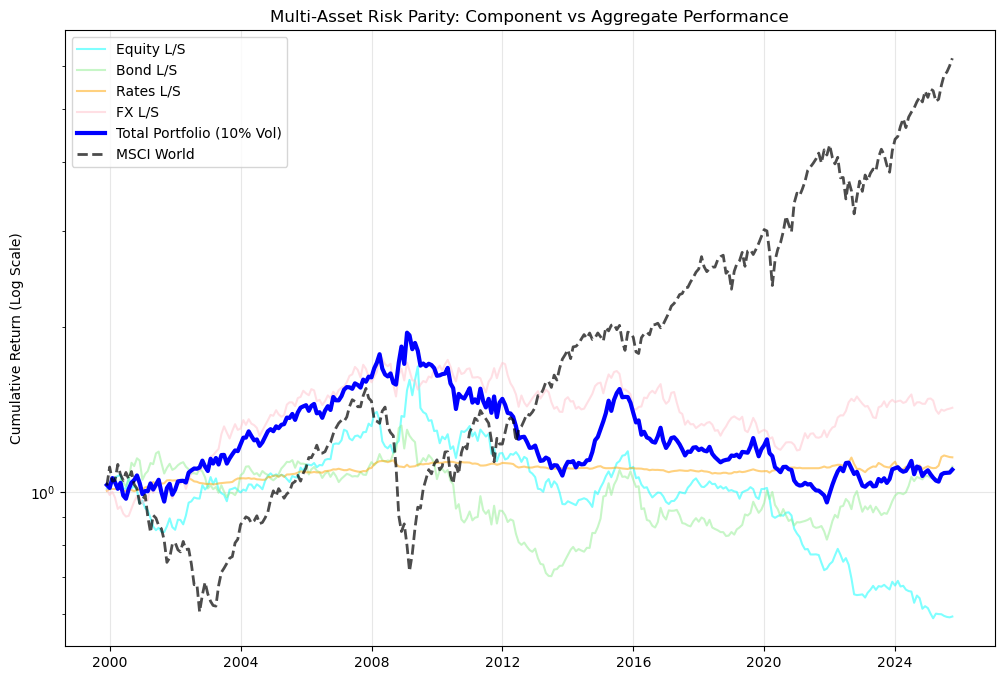

In [12]:
# =============================================================================
# --- CONFIGURATION & CONSTANTS ---
# =============================================================================

# Paths & Targets
VOL_TARGET = 0.10
DATA_PATH = '../Data/'

# Strategy Parameters
MOMENTUM_LOOKBACKS = [1, 3, 12]  # Months for signal generation
SIGNAL_LAG = 1                   # Lag to apply to signal
K_SELECT = 3                     # Number of assets to select (CS Momentum)
MIN_ASSETS = 4                   # Min assets required to trade

# Risk Management & Costs
RF_ANNUAL = 0.02                 # Assumed risk-free rate (2%)
T_COST_BPS = 0.0000              # Transaction costs (10 basis points)
MAX_SCALAR_STRATEGY = 3.0        # Max leverage cap for individual asset class
MAX_SCALAR_PORTFOLIO = 3.0       # Max leverage cap for final aggregated portfolio

# Time & Frequency
ANNUALIZATION_FACTOR = 12
RESAMPLE_FREQ = "ME"             # Month End

# Derived Constants
RF_MONTHLY = RF_ANNUAL / ANNUALIZATION_FACTOR
T_COST = T_COST_BPS              # Passing directly as decimal if pmp expects decimal, or bps if expected bps

# =============================================================================
# 1. THE STRATEGY FACTORY
# =============================================================================
def run_independent_strategy(name, df_prices, benchmark, k_select=K_SELECT, min_assets=MIN_ASSETS):
    """
    Runs a complete, isolated Momentum L/S strategy for a single asset class.
    """
    print(f"\n--- RUNNING STRATEGY: {name} ---")
    print(f"   Assets: {len(df_prices.columns)}")
    
    # A. Prepare Data
    returns = df_prices.pct_change().fillna(0)
    rf_series = pd.Series(RF_MONTHLY, index=returns.index, name="RF")
    dummy_benchmark = returns.mean(axis=1) 
    
    # B. Signal Generation
    raw_signal = pd.DataFrame(0.0, index=df_prices.index, columns=df_prices.columns)
    
    for lag in MOMENTUM_LOOKBACKS:
        mom = df_prices.pct_change(lag)
        sig = np.sign(mom)
        raw_signal += sig
    
    final_signal = raw_signal / len(MOMENTUM_LOOKBACKS)
    
    # C. Weight Generation
    weights = pmp.make_country_weights(
        signal=final_signal,
        returns=returns,
        benchmark_series=dummy_benchmark,
        k=k_select,            
        long_short=True,
        beta_neutral=False,    
        signal_lag=SIGNAL_LAG,
        min_regions=min_assets 
    )
    
    # D. Preliminary Backtest (Unscaled)
    # We use 0.0 cost here to get pure realized volatility for scaling
    res_unscaled = pmp.run_cc_strategy(
        weights=weights,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=0.0, 
        benchmark=benchmark
    )
    
    # E. Volatility Targeting
    ret_series = res_unscaled["ret_net"].dropna()
    realized_vol = ret_series.std() * np.sqrt(ANNUALIZATION_FACTOR)
    
    if realized_vol > 0:
        scalar = VOL_TARGET / realized_vol
        scalar = min(scalar, MAX_SCALAR_STRATEGY) 
    else:
        scalar = 1.0
        
    print(f"   Realized Vol (Unscaled): {realized_vol:.2%}")
    print(f"   Scaling Factor: {scalar:.2f}x")
    
    # F. Final Scaled Backtest
    weights_scaled = weights * scalar
    res_final = pmp.run_cc_strategy(
        weights=weights_scaled,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=T_COST, 
        benchmark=benchmark
    )
    
    return res_final

# =============================================================================
# 2. DATA LOADING & PREPROCESSING
# =============================================================================

def load_and_process(filename, suffix, is_fx=False):
    """
    Helper to load and process data to avoid repetition.
    """
    print(f"Loading {suffix}...")
    full_path = os.path.join(DATA_PATH, filename)
    
    # Handle FX Returns vs Price data structure
    if is_fx:
        df = pd.read_excel(full_path, sheet_name="RETURNS", engine='openpyxl')
    else:
        df = pd.read_excel(full_path, engine='openpyxl')
        
    # Index setting
    if 'Date' in df.columns: df = df.set_index('Date')
    elif 'Dates' in df.columns: df = df.set_index('Dates')
    else: df = df.set_index(df.columns[0])
    
    df.index = pd.to_datetime(df.index, errors='coerce')
    
    # FX Special handling (cumprod of returns to get price index)
    if is_fx:
        df = (1 + df.fillna(0)).cumprod() * 100
    
    # Renaming and Resampling
    df.columns = [f"{c}_{suffix}" for c in df.columns]
    df = df.apply(pd.to_numeric, errors='coerce').resample(RESAMPLE_FREQ).last().ffill()
    return df

# --- Load Assets ---
df_eq = load_and_process("Equity Data.xlsx", "Eq")
df_bd = load_and_process("Bond Data.xlsx", "Bd")
df_rt = load_and_process("Interest Rates Data.xlsx", "Rt")
df_fx = load_and_process("FX Data.xlsx", "FX", is_fx=True)

# --- Load Benchmark ---
df_bench = pd.read_excel(os.path.join(DATA_PATH, "Benchmarks.xlsx"), engine='openpyxl')
if 'Date' in df_bench.columns: df_bench = df_bench.set_index('Date')
else: df_bench = df_bench.set_index(df_bench.columns[0])
df_bench.index = pd.to_datetime(df_bench.index, errors='coerce')
df_bench = df_bench.resample(RESAMPLE_FREQ).last().ffill()
benchmark_ret = df_bench['MSCI World'].pct_change().fillna(0)

# =============================================================================
# 3. EXECUTION PER ASSET CLASS
# =============================================================================

ret_equity = run_independent_strategy("EQUITY", df_eq, benchmark=benchmark_ret)
ret_bond = run_independent_strategy("BOND", df_bd, benchmark=benchmark_ret)
ret_rates = run_independent_strategy("RATES", df_rt, benchmark=benchmark_ret)
ret_fx = run_independent_strategy("FX", df_fx, benchmark=benchmark_ret)

# =============================================================================
# 4. AGGREGATION & PORTFOLIO CONSTRUCTION
# =============================================================================

# Combine Strategies
df_strategies = pd.DataFrame({
    'Equity': ret_equity["ret_net"],
    'Bond': ret_bond["ret_net"],
    'Rates': ret_rates["ret_net"],
    'FX': ret_fx["ret_net"]
}).dropna()

# Portfolio Construction (Equal Weight across strategies)
final_portfolio_ret = df_strategies.mean(axis=1)

# Re-Scale to Target Vol
port_vol = final_portfolio_ret.std() * np.sqrt(ANNUALIZATION_FACTOR)
final_scalar = VOL_TARGET / port_vol if port_vol > 0 else 1.0
final_scalar = min(final_scalar, MAX_SCALAR_PORTFOLIO)
final_portfolio_ret = final_portfolio_ret * final_scalar

print(f"\nFinal Portfolio Re-Scaling Factor: {final_scalar:.2f}x")

# Create Consolidated Dataframe for Summary
df_all = df_strategies.copy()
df_all['Total_Portfolio'] = final_portfolio_ret

# Align everything
common_idx = df_all.index.intersection(benchmark_ret.index)
df_all = df_all.loc[common_idx]
bm_aligned = benchmark_ret.loc[common_idx]
rf_aligned = pd.Series(RF_MONTHLY, index=common_idx)

# Calculate Excess Returns
xs_all = df_all.sub(rf_aligned, axis=0)
xs_bench = (bm_aligned - rf_aligned).to_frame()

# =============================================================================
# 5. SUMMARY
# =============================================================================

print("\n=======================================================")
print("             PERFORMANCE SUMMARY PER ASSET CLASS       ")
print("=======================================================")

summary = pmp.summarizePerformance(
    xsReturns=xs_all.values,
    Rf=rf_aligned.values.reshape(-1, 1),
    factorXsReturns=xs_bench.values, 
    annualizationFactor=ANNUALIZATION_FACTOR,
    strategyNames=df_all.columns.tolist()
)

print(summary)

# Correlation Matrix
print("\n--- Correlation Matrix ---")
print(df_all.corr().round(2))

# =============================================================================
# 6. VISUALIZATION
# =============================================================================
cum_all = (1 + df_all).cumprod()
cum_bench = (1 + bm_aligned).cumprod()

plt.figure(figsize=(12, 8))
colors = ['cyan', 'lightgreen', 'orange', 'pink']

# Plot Components
for i, col in enumerate(df_strategies.columns):
    plt.plot(cum_all[col], label=f"{col} L/S", alpha=0.5, linewidth=1.5, color=colors[i])

# Plot Total & Benchmark
plt.plot(cum_all['Total_Portfolio'], label=f"Total Portfolio ({VOL_TARGET:.0%} Vol)", color="blue", linewidth=3)
plt.plot(cum_bench, label="MSCI World", color="black", linestyle="--", linewidth=2, alpha=0.7)

plt.title("Multi-Asset Risk Parity: Component vs Aggregate Performance")
plt.ylabel("Cumulative Return (Log Scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Equity Table

In [13]:
ret_equity
ret_equity.to_csv("../Results/trend_equity.csv")

## Bond Table

In [14]:
ret_bond
ret_bond.to_csv("../Results/trend_bond.csv")

## Rate Table

In [15]:
ret_rates
ret_rates.to_csv("../Results/trend_rates.csv")

## FX Table

In [16]:
ret_fx
ret_fx.to_csv("../Results/trend_fx.csv")